In [1]:
import numpy as np
from scipy import stats, linalg, optimize

import matplotlib.pyplot as plt

## Functions

In [2]:
def mchlis_ment(x):
    ''' Ground truth Michaelis Menton model
    
    Arguments:
        x - inputs variables, float or np.array
    
    Returns:
        ζ - ground truth model evaluates at x, float or np.array
    '''
    
    ζ = 0.65*x/(1 + x/20)
    
    return ζ

def sq_exp(x1, x2, σsq):
    '''Computes the covariance matrix with the squared exponential kernel function
    
    Agruments:
        x1 - co-variates, n1-dimensional np.array
        x2 - co-variates, n2-dimensional np.array
        σsq - variance of model, float
    
    Returns:
        Σ - covariance matrix, nxn np.array
        
    Additional Notes:
        The squared exponential kernel k(x1,x2) is computed by k(x1,x2) = σ^2 exp(-(x1-x2)^2)
    '''
    
    # initialize covariance matrix
    n1 = len(x1)
    n2 = len(x2)
    Σ = np.zeros([n1,n2])
    
    # build covariance
    for i in range(n1):
        for j in range(n2):
            Σ[i,j] = σsq*np.exp(-((x1[i] - x2[j])/4)**2)
    
    return Σ

def gls_est(X, y, Σ):
    
    ''' Computes the generalized least sqaures (gls) estimator for data (X,y) and covariance Σ
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
    
    Returns:
        θ_hat - generalized least sqaures estimator, px1 np.array
        
    Additional Notes:
        The gls estimator is computed by θ_hat = (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    '''
    
    # Solve linear system z = Σy for z to get Σ^-1 y 
    z = np.linalg.solve(Σ, y)

    # Solve linear system W = ΣX for W to get Σ^-1 X 
    W = np.linalg.solve(Σ, X)
    
    # transpose matrix of regressors
    XT = np.transpose(X)

    # compute first term: X^T Σ^-1 X
    term1 = np.dot(XT, W)

    # compute second term: X^T Σ^-1 y
    term2 = np.dot(XT, z)

    # compute gls estimator (X^T Σ^-1 y)^-1 (X^T Σ^-1 y)
    θ_hat = np.linalg.solve(term1, term2)

    return θ_hat


def ssr_cholesky(X, y, Σ, θ_hat):
    '''Computes the weighted sum of squared residuals (SSR) with Cholesky decomposition
    
    Arguments:
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        Σ - covariance matrix, nxn np.array
        θ_hat - generalized least sqaures estimator, px1 np.array
    
    Returns:
        ssr - weighted sum of squared residuald
    
    Additional Notes:
        The sum of squared residuals in matrix notation is given by (y - Xθ_hat)^T Σ^-1 (y - Xθ_hat).
        Cholesky factorization of Σ yields Σ = L^T L.
    '''
    
    # compute residuals (y - Xθ_hat)
    resd =  y - np.dot(X, θ_hat)
    
    # Cholesky facorization, Σ = L^T L
    L, lower = linalg.cho_factor(Σ, lower = True)
    
    # Cholesky decomposition 1, r = L^-1 (y - Xθ_hat)
    r = linalg.solve(L, resd)
    
    # compute ssr
    ssr = np.dot(np.transpose(r), r)
    
    return ssr

def log_like(σsq, X, y):
    '''Computes the negative log-likelihood of the a linear model assuming iid Normal observation error
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ℓ - log-likelihood, float
    '''
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build discrepancy covariance
    Σ_δ = sq_exp(X[:,0], X[:,0], σδsq)
    
    # build noise covariance
    Σ_ϵ = σϵsq*np.identity(len(X[:,0]))
    
    # build total covariance
    Σ = Σ_δ + Σ_ϵ

    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ)

    # compute weight sum of sqaured residuals with cholesky decomposition
    ssr = ssr_cholesky(X, y, Σ, θ_hat)
    
    # compute negtaive log-likelihood
    ℓ = 1/2*(np.log(np.linalg.det(Σ)) + ssr)
    
    return ℓ

def est_ζ(σsq, X, y):
    ''' Estimates the ground truth model ζ
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
    
    Returns:
        ζ_hat - estimated ground truth model, nx1 np.array
    '''
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build discrepancy covariance
    Σδ_hat = sq_exp(X[:,0], X[:,0], σδsq) 
    
    # build noise covariance
    Σϵ_hat = σϵsq*np.identity(len(X[:,0]))
    
    # build total covariance
    Σ_hat = Σδ_hat + Σϵ_hat
    
    # compute generalized least squares estimator
    θ_hat = gls_est(X, y, Σ_hat)
    
    # compute misspecifed model η(x,θ_hat)
    η_hat = np.dot(X, θ_hat)
    
    # compute Σ_hat^-1 η(x,θ_hat)
    z = np.linalg.solve(Σ_hat, y - η_hat)
    
    # compute estimates
    ζ_hat = η_hat + np.dot(Σδ_hat, z)
    
    return ζ_hat

def gp_predict(σsq, X, y, x_star):
    
    ''' Predicts ground truth model ̂ζ with point estimates of GP
    
    Arguments:
        σsq - variance of discrepancy model σδsq and observation error  σϵsq, 2x1 array-like
        X - regressors, nxp np.array
        y - observations, nx1 np.array
        x_star - predictors, npx1 np.array
    
    Returns:
        ζ_star - predicted ground truth model, npx1 np.array
    '''
    
    ## build covariance matrix
    
    # unpack parameters
    σδsq, σϵsq = σsq
    
    # build observations covariance
    Σxx = sq_exp(X[:,0], X[:,0], σδsq) + σϵsq*np.identity(len(X[:,0]))
    
    # get ols estimate
    θ = gls_est(X, y, Σxx)
    
    # build off-diagonals
    Σxx_star = sq_exp(X[:,0], x_star, σδsq)
    Σx_starx = np.transpose(Σxx_star)
    
    # build prediction variance
    Σx_starx_star = sq_exp(x_star, x_star, σδsq)
    
    ## compute conditional mean
    
    # cholesky factorization
    L, lower = linalg.cho_factor(Σxx, True)
    
    # solve linear system 1
    α = linalg.solve(L, y - np.dot(X,θ))
    
    # solve linear system 2
    β = linalg.solve(np.transpose(L), α)
    
    # conditional mean
    μ_star = x_star*θ + np.dot(Σx_starx, β)
    
    ## compute conditional covariance
    
    # solve linear system
    γ = linalg.solve(L, Σxx_star)
    
    # compute covariance matrix
    Σ_star = Σx_starx_star - np.dot(np.transpose(γ), γ)
    
    return μ_star, Σ_star

## Synthetic data generation

In [3]:
## generate synthetic data

# set seed for reproducibility
np.random.seed(234)

# select independent variables
x = np.linspace(0, 10, 10)

# compute ground truth model
ζ = mchlis_ment(x)

# set ground truth variance of noise
σϵsq_tru = 0.05

# generate i.i.d. normal measurement error, ϵ_1 ,..., ϵ_n ~iid N(0,σϵsq_tru)
ϵ = stats.norm.rvs(loc = 0, scale = np.sqrt(σϵsq_tru), size = len(x))

# generate observations
y = ζ + ϵ

## Linear model misspecification and visualization

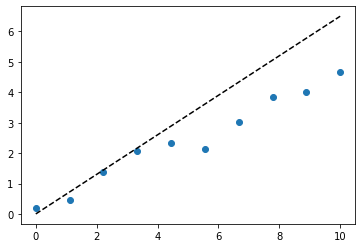

In [4]:
# choose parameter(s) of misspecified model η(x,θ)
θ = np.array([0.65])

# build nxp matrix of regressors
X = np.tile(x,len(θ)).reshape(len(x),len(θ))

# visualize misspecified model fit to data
plt.plot(x,y,'o')
plt.plot(x,np.dot(X,θ),'k--')

## Set bounds and initial values for parameter estimation

In [11]:
## variance of discrepancy
# lower bound
σδsq_lo = 0.01
# upper bound
σδsq_hi = 10
# inital guess
σδsq_0 = 0.07

## variance of noise
# lower bound
σϵsq_lo = 0.01
# upper bound
σϵsq_hi = 10
# inital guess
σϵsq_0 = 0.1

## concatenate bounds and inital guesses
# bounds
bds = [(σδsq_lo, σδsq_hi),(σϵsq_lo, σϵsq_hi)]
# inital guesses
σsq_0 = [σδsq_0, σϵsq_0]

## Optimization

In [12]:
results = optimize.minimize(log_like, x0 = σsq_0, args = (X, y), method = 'trust-constr', bounds = bds)
results

C:\Users\kilaj\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


 barrier_parameter: 6.400000000000003e-06
 barrier_tolerance: 6.400000000000003e-06
          cg_niter: 25
      cg_stop_cond: 1
            constr: [array([0.01000022, 0.07616097])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.10687112808227539
               fun: -7.583380697454018
              grad: array([2.92109919e+01, 9.63211060e-05])
               jac: [<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([0.00000000e+00, 1.01213026e-09])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 57
              nhev: 0
               nit: 24
             niter: 24
              njev: 19
        optimality: 1.012130262725299e-09
            status: 1
           success: True
         tr_radius: 26472.42499796203
                 v: 

# Estimation and prediction

In [13]:
# unpack results of optimizations
σsq = results.x

# estimate fit to data
ζ_hat = est_ζ(σsq, X, y)

# predict outside training data
x_star = np.linspace(0,15)
μ, Σ = gp_predict(σsq, X, y, x_star)

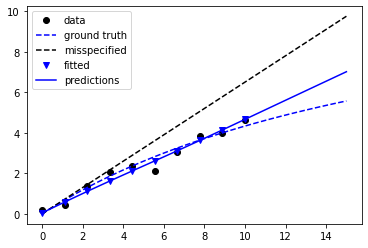

In [15]:
# plot data
plt.plot(x, y,'ko', label = 'data')

# plot ground truth model
plt.plot(x_star, mchlis_ment(x_star),'b--', label = 'ground truth')

# plot misspecified model
plt.plot(x_star,np.dot(x_star,0.65),'k--', label = 'misspecified')

# plot estimates
plt.plot(x, ζ_hat,'bv', label = 'fitted')

# plot predictions
plt.plot(x_star, μ, 'b-', label = 'predictions' )
plt.legend()